In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

np.random.seed(40)

In [22]:
# Data Load
df_train = pd.read_csv('train.csv')
df_train = df_train.iloc[:,1:]
df_train.columns = ['hour', 'temp', 'precip',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2_5', 'count']
df_X = df_train[df_train.columns.drop('count')]
df_y = df_train['count'].values

X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [23]:
# Visualize Pipeline
from sklearn import set_config

set_config(display="diagram")

In [24]:
# Data Preprocessing
numeric_features = list(df_X.columns.drop(['precip','hour']))
numeric_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='median')),("scaler",StandardScaler())]
)
hour_feature = ['hour']
hour_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='most_frequent')),('scaler',StandardScaler(with_std=False))]
 ) # hour은 standardscaler에서 표준편차로 나누는 것은 제외함.
hour_transformer_oh = OneHotEncoder(handle_unknown='ignore',sparse=False) # hour을 onehotencoding으로 처리

categorical_features = ['precip']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('hour', hour_transformer, hour_feature),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [25]:
# Tree Regressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = Pipeline(
    steps=[("preprocessor",preprocessor),
    ("tree",DecisionTreeRegressor(criterion="squared_error"))]
)
tree_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'windspeed',
                                                   'humidity', 'visibility',
                                                   'ozone', 'pm10', 'pm2_5']),
                                                 ('hour',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler(with_std=False))]),
                                                  ['hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['precip'])])),
                ('tree', DecisionTreeRegressor())])

In [27]:
# Tree Info and Validation RMSE
tree_res = tree_reg.named_steps['tree']
tree_res.get_depth() # 20
tree_res.get_n_leaves() # 967
tree_pred = tree_reg.predict(X_val)
np.sqrt(mean_squared_error(y_val, tree_pred)).round(3) # 50.643


50.643

In [56]:
# Check whether Overfitted with Cross-Validation
from tqdm import * # Progress-bar
from sklearn.model_selection import GridSearchCV
params = {'max_features':("sqrt","log2","auto"), "max_depth" : list(range(2, 41, 2))}

# GridSearch Algorithm
N_comb = len(params['max_features']) * len(params['max_depth'])
with tqdm(total=N_comb) as pbar:
    df = []
    for feat in params['max_features']:
        scores = []
        for d in params['max_depth']:
            reg_i = Pipeline(
                steps=[('preprocessor',preprocessor),('tree',DecisionTreeRegressor(max_features=feat,max_depth=d))]
            )
            reg_i.fit(X_train,y_train)
            pred_i = reg_i.predict(X_val)
            score_i = np.sqrt(mean_squared_error(y_val, pred_i)).round(3)
            scores.append(score_i)
            pbar.update()
        df.append(scores)
res = pd.DataFrame(df, index=params['max_features'], columns=params['max_depth']).T

100%|██████████| 60/60 [00:00<00:00, 71.35it/s]

      sqrt    log2    auto
2   66.708  60.810  55.686
4   60.555  58.344  46.951
6   53.053  49.551  43.956
8   51.672  52.580  47.578
10  51.377  54.798  47.461
12  58.142  57.158  51.927
14  56.010  56.304  50.712
16  52.690  58.552  51.989
18  60.741  52.247  49.761
20  56.091  51.574  49.415
22  58.884  57.347  50.195
24  50.040  58.215  50.119
26  55.343  58.891  47.630
28  57.231  55.625  49.617
30  59.519  55.725  50.054
32  61.582  56.997  51.894
34  58.306  59.351  49.961
36  58.284  61.232  47.542
38  53.903  51.726  50.916
40  63.853  54.104  50.922


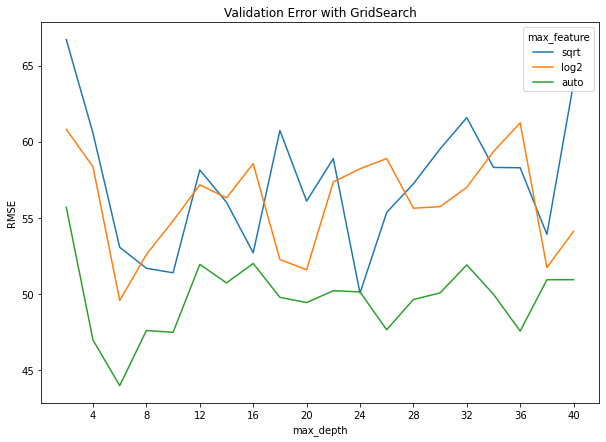

In [60]:
# Plot the result of GridSearch
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(res.index, res['sqrt'], label = 'sqrt')
plt.plot(res.index, res['log2'], label = 'log2')
plt.plot(res.index, res['auto'], label = 'auto')
plt.legend(title = "max_feature", loc = 'upper right')
plt.xticks(range(4,44,4))
ax.set(xlabel="max_depth", ylabel="RMSE", title="Validation Error with GridSearch")
plt.savefig("plots/GridSearch_Tree.png", facecolor = 'white', transparent = False)

In [127]:
# Tree with PCA
from sklearn.decomposition import PCA
tree_pca_1 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_depth=6))]
)
tree_pca_2 = Pipeline(
    steps=[('preprocessor',preprocessor),
        ('pca', PCA(n_components=3)),
        ('tree',DecisionTreeRegressor(max_depth=26))]
)
tree_pca_1.fit(X_train, y_train)
tree_pca_2.fit(X_train, y_train)

pred_1 = tree_pca_1.predict(X_val)
pred_2 = tree_pca_2.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,pred_1)).round(3))
print(np.sqrt(mean_squared_error(y_val,pred_2)).round(3))

49.545
63.731


100%|██████████| 60/60 [00:01<00:00, 52.07it/s]


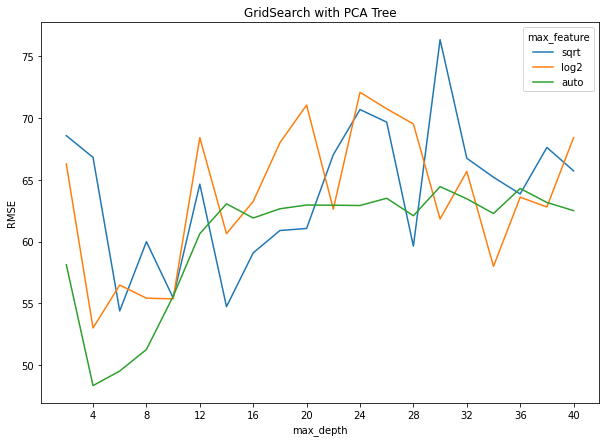

In [128]:
# GridSearch with PCA Tree
params = {'max_features':("sqrt","log2","auto"), "max_depth" : list(range(2, 41, 2))}
N_comb = len(params['max_features']) * len(params['max_depth'])
with tqdm(total=N_comb) as pbar:
    df = []
    for feat in params['max_features']:
        scores = []
        for d in params['max_depth']:
            reg_i = Pipeline(
                steps=[('preprocessor',preprocessor),('pca',PCA(n_components=3)),('tree',DecisionTreeRegressor(max_features=feat,max_depth=d))]
            )
            reg_i.fit(X_train,y_train)
            pred_i = reg_i.predict(X_val)
            score_i = np.sqrt(mean_squared_error(y_val, pred_i)).round(3)
            scores.append(score_i)
            pbar.update()
        df.append(scores)
res = pd.DataFrame(df, index=params['max_features'], columns=params['max_depth']).T

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(res.index, res['sqrt'], label = 'sqrt')
plt.plot(res.index, res['log2'], label = 'log2')
plt.plot(res.index, res['auto'], label = 'auto')
plt.legend(title = "max_feature", loc = 'upper right')
plt.xticks(range(4,44,4))
ax.set(xlabel="max_depth", ylabel="RMSE", title="GridSearch with PCA Tree")
plt.savefig("plots/GridSearch_TreewithPCA.png", facecolor = 'white', transparent = False)

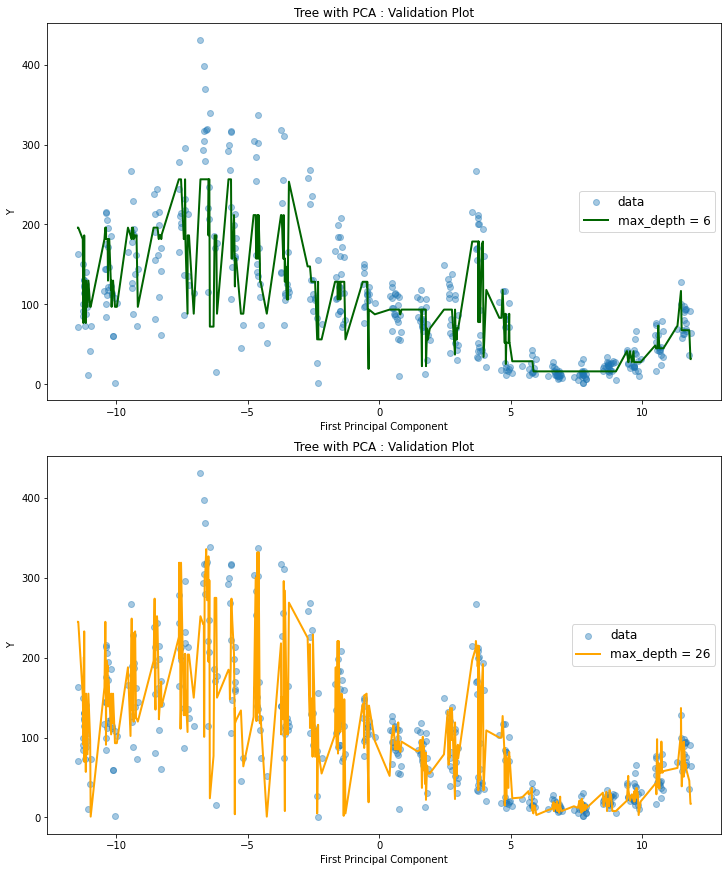

In [126]:
# Compare three Local_Minimum RMSE spot
# Projeted on the first Principal Component
pca = tree_pca_1[0:2] # Pipeline until PCA
xs_1, ys_1 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_1.predict(X_val))))
xs_2, ys_2 = zip(*sorted(zip(pca.transform(X_val)[:,0],tree_pca_2.predict(X_val))))
# Plot
fig, axes = plt.subplots(2,1,figsize=(10,12), constrained_layout=True)
axes[0].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[0].plot(xs_1, ys_1, label = 'max_depth = 6', color = "darkgreen", linewidth = 2)
axes[0].legend(fontsize = 12, loc = 'center right')
axes[0].set(xlabel = "First Principal Component", ylabel="Y",title="Tree with PCA : Validation Plot")

axes[1].scatter(pca.transform(X_val)[:,0], y_val, alpha=0.4, label='data')
axes[1].plot(xs_2, ys_2, label = 'max_depth = 26', color = "orange", linewidth = 2)
axes[1].legend(fontsize = 12, loc = 'center right')
axes[1].set(xlabel = "First Principal Component", ylabel="Y",title="Tree with PCA : Validation Plot")
plt.savefig("plots/tree_pca.png", transparent=False, facecolor='white')

In [94]:
ls_1 = 
xs_1, ys_1 = ls_1

(-11.45241081036861,
 -11.440050863403776,
 -11.269242436630702,
 -11.2473626532368,
 -11.246259966040057,
 -11.243294595446585,
 -11.238917197507634,
 -11.226952171318947,
 -11.222896789526601,
 -11.214640496388526,
 -11.210503958558704,
 -11.195637172308276,
 -11.161586132070102,
 -11.153735585401158,
 -11.153429704773506,
 -11.144937343150852,
 -11.089847394193377,
 -11.056050299024788,
 -10.987514577796055,
 -10.968846321529218,
 -10.444460023246766,
 -10.410501857277461,
 -10.392734521050299,
 -10.3866078171943,
 -10.381198151016251,
 -10.380398772756264,
 -10.373356321104138,
 -10.367274226947814,
 -10.350998773962488,
 -10.34996333872408,
 -10.328462082948128,
 -10.323611029296163,
 -10.30976369951762,
 -10.297748914118648,
 -10.261702902047045,
 -10.190985632813158,
 -10.182397092850165,
 -10.173086931844198,
 -10.152346140427088,
 -10.13684525792646,
 -10.118110513033663,
 -10.044744168270427,
 -10.032829258011809,
 -9.97412915900117,
 -9.550717104544733,
 -9.453464949200445,
